# Experimentting with Auto-encoders on the Fashion MNIST dataset

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

Normlaize training data so the pixel values are between 0 and 1

In [32]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


First we create an Autoencoder class to construct an autoencoder

In [35]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, encoding_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim) 

Use adam and MSE error

In [36]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [6]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0237 - val_loss: 0.0131
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0116 - val_loss: 0.0107
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0101 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0095 - val_loss: 0.0095
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0092 - val_loss: 0.0091
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.008

We use the encoder to map the images from the test set to the latent vector space and then use the decoder to map from the latent vector space back to the images.

In [37]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()


Plot the original test images against their 'reconostructed' selves

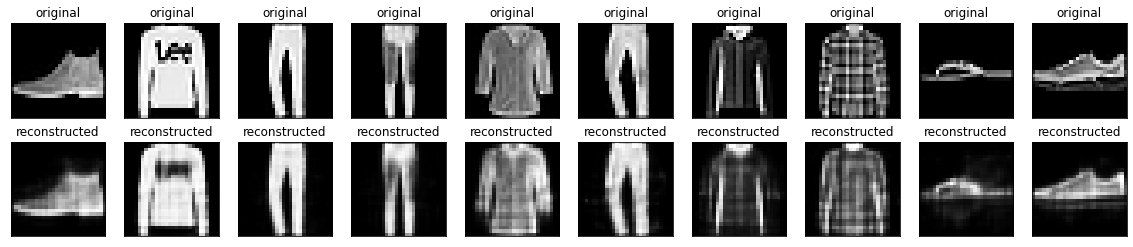

In [14]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

Now we try to train an autoencoder that takes noisy images of our dataset and tries to remove the noise from the images

In [38]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [39]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


Inject noise into the images

In [17]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

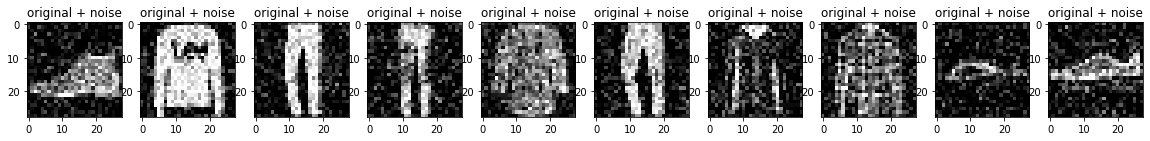

In [18]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

Define our 'Denoise' model's architecture, and train it using adam and MSE for 10 epochs.

In [40]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)), 
      layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2)])
    
    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [41]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [21]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 57s 30ms/step - loss: 0.0158 - val_loss: 0.0090
Epoch 2/10
1875/1875 [==============================] - 57s 31ms/step - loss: 0.0083 - val_loss: 0.0079
Epoch 3/10
1875/1875 [==============================] - 59s 31ms/step - loss: 0.0075 - val_loss: 0.0073
Epoch 4/10
1875/1875 [==============================] - 58s 31ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 5/10
1875/1875 [==============================] - 51s 27ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 6/10
1875/1875 [==============================] - 47s 25ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 7/10
1875/1875 [==============================] - 60s 32ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 8/10
1875/1875 [==============================] - 345s 184ms/step - loss: 0.0068 - val_loss: 0.0067
Epoch 9/10
1875/1875 [==============================] - 54s 29ms/step - loss: 0.0067 - val_loss: 0.0067
Epoch 10/10
1875/1875 [==============================] - 53s 2

In [24]:
autoencoder.encoder.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 8)           1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [25]:
autoencoder.decoder.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 8)         584       
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 1)         145       
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


Here we plot the original images and their respective denoised images.

In [26]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

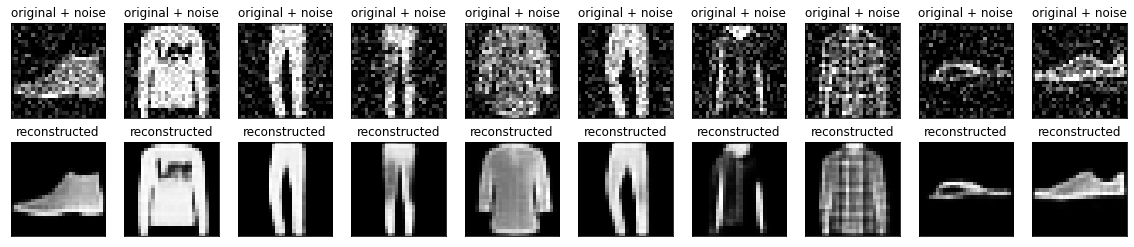

In [27]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()